In [1]:
import datetime
import json
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import cv2
import dask
import dask.array as da

from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.applications import inception_v3, resnet_v2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 
from data_science.graph_utils import graph_model_history
from data_science.keras.model_checkpoint_gcs import ModelCheckpointGCS
from data_science.keras.cnn_models import basic_cnn_model, basic_cnn_model_with_regularization, pretrained_model
from data_science.serialization_utils import numpy_to_json, sklearn_precision_recall_curve_to_dict
from data_science.sklearn_batch_generator import SklearnBatchGenerator
from data_science.train import get_model_and_metadata_from_gcs, train_keras_model
from data_science.data_manipulation import balanced_class_train_test_splits

In [2]:
print(tf.test.gpu_device_name())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())

/device:GPU:0
True
True


In [2]:
root = '/home/jovyan/work'
os.listdir(root)

['anaconda',
 '.config',
 'Music',
 '.serverlessrc',
 '.bash_profile-anaconda.bak',
 '.kaggle',
 '.condarc',
 '.docker',
 '.gsutil',
 '.ivy2',
 '.bash',
 '.node-gyp',
 'octave-workspace',
 '.DS_Store',
 '.gnupg',
 '.CFUserTextEncoding',
 'test',
 '.wget-hsts',
 '.bashrc',
 '.local',
 '.psql_history',
 'Pictures',
 '.bigqueryrc',
 '.nvm',
 '.rnd',
 '.boto',
 '.ipython',
 'Desktop',
 'Library',
 '.matplotlib',
 '.electron',
 '.lesshst',
 '.oracle_jre_usage',
 '.bash_profile.pysave',
 '.octave_hist',
 '.android',
 'airflow',
 '.pgadmin',
 '.cups',
 '.bash_sessions',
 '.helm',
 '.serverless',
 'PycharmProjects',
 'Public',
 '.dropbox',
 '.catalyst',
 '.idlerc',
 '.kube',
 '.anaconda',
 'model',
 '.ssh',
 'Movies',
 'Applications',
 '.jenv',
 '.gradle',
 'Dropbox',
 '.bitmonero',
 '.Trash',
 '.ipynb_checkpoints',
 '.jupyter',
 '.keras',
 '.npm',
 '.terraform.d',
 'Documents',
 '.pyenv',
 '.zipline',
 '.m2',
 '.gcs',
 '.bash_profile',
 'data',
 'Downloads',
 '.python_history',
 'spark_depend

In [3]:
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/app/.gcs/credentials.json'
gcs_client = storage.Client()
bucket = gcs_client.bucket("big_earth")

metadata_dir = os.path.join(root, "data/metadata")
npy_image_dir = os.path.join(root, "data/npy_image_files")

n_classes = 1
n_epochs = 100
batch_size = 128

early_stopping_patience = 10
use_small_dataset = False
use_random_small_dataset = False

project_name = "cloud_and_shadow"
model_dir = os.path.join(root, "model/models")
log_dir = os.path.join(root, "model/logs")

gcs_hyperparameter_opt_record_dir = "model/hyperparameter_opt_record"
hyperparameter_opt_record_dir = os.path.join(root, gcs_hyperparameter_opt_record_dir)
# blob prefix
gcs_model_dir = "model/models"
# tensorboard
gcs_log_dir = "gs://big_earth/model/logs"


for directory in [metadata_dir, npy_image_dir, log_dir, model_dir, hyperparameter_opt_record_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

In [ ]:
def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = npy_image_dir + "/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + '/data/metadata.csv')
df = prepare_data(df)
print(df['binarized_labels'].iloc[0].shape)
print(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

In [ ]:
has_cloud_and_shadow = df[df['has_cloud_and_shadow'] == 1]
sample_no_cloud_and_shadow = df[df['has_cloud_and_shadow'] == 0].sample(
    n=len(has_cloud_and_shadow), random_state=random_seed)
print(len(sample_no_cloud_and_shadow), len(sample_no_cloud_and_shadow), len(has_cloud_and_shadow), len(has_cloud_and_shadow))

train, valid, test = balanced_class_train_test_splits(*[sample_no_cloud_and_shadow, has_cloud_and_shadow])
print(len(train), len(valid), len(test))

In [11]:
band_stats = pd.read_csv(metadata_dir + '/band_stats.csv')
band_stats[band_stats['dataset'] == 'all_small']

augmentations_train = Compose([
    Flip(p=0.5),
    Rotate(limit=(1, 360), p=0.5),
])

In [9]:
x_train = train['image_path'].values
x_valid = valid['image_path'].values
x_test = test['image_path'].values

target = 'has_cloud_and_shadow_target'
y_train = np.stack(train[target].values)
y_valid = np.stack(valid[target].values)
y_test = np.stack(test[target].values)

print(y_train.shape, y_train[0].shape)

if use_small_dataset:
    size = batch_size
    n_epochs = 3
    x_train = np.concatenate([x_train[:size], x_train[-size:]])
    x_valid = np.concatenate([x_valid[:size], x_valid[-size:]])
    x_test = np.concatenate([x_test[:size], x_test[-size:]])

    y_train = np.concatenate([y_train[:size], y_train[-size:]])
    y_valid = np.concatenate([y_valid[:size], y_valid[-size:]])
    y_test = np.concatenate([y_test[:size], y_test[-size:]])
elif use_random_small_dataset:
    shape = (100, 1)
    x_train = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_train = np.concatenate([np.ones(shape), np.zeros(shape)])

    x_valid = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_valid = np.concatenate([np.ones(shape), np.zeros(shape)])

    y_train = np.random.randint(0, 2, (len(train), 44))
    y_valid = np.random.randint(0, 2, (len(valid), 44))
    y_test = np.random.randint(0, 2, (len(test), 44))
    y_test_labels = test['labels'].values

    
print(y_train.shape, y_train[0].shape)

(1907, 1) (1,)
(1907, 1) (1,)


len(train): 10
Epoch 1/2
1/1 [==============================] - 21s 21s/step - loss: 0.6983 - accuracy: 0.8000
Epoch 2/2
1/1 [==============================] - 27s 27s/step - loss: 2.4259e-06 - accuracy: 1.0000


/app/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb946626518>]],
      dtype=object)

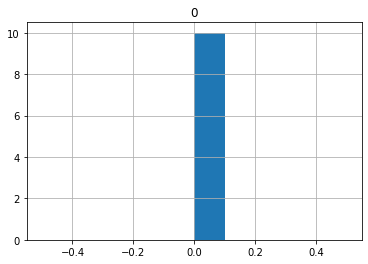

In [135]:
# Overfit on all training data
model = basic_cnn_model((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_2020_1_31_test"

result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train[:10], y_train=y_train[:10], x_valid=None, y_valid=None, image_augmentations=None, image_processor=None,
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=2, early_stopping_patience=10)
pd.DataFrame(result['y_pred_probs_train']).hist()

In [65]:
valid_generator = get_image_dataset(x=x_valid, y=y_valid, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
actual_y_valid, pred_y_valid, pred_y_valid_probs = get_predictions_for_dataset(valid_generator, model) 
print('val_loss', binary_crossentropy(actual_y_valid, pred_y_valid_probs).numpy())
print('val_accuracy', accuracy_score(actual_y_valid, pred_y_valid))

val_loss 7.061103
val_accuracy 0.541501976284585


In [13]:
# Start basic_cnn_model_with_regularization by adding batch normalization and validation set 
model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
experiment_name = f"{project_name}_keras_cnn_bn_2020_2_14"
result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=None, image_processor=None,
    band_stats=band_stats,
    model_name='keras_cnn_bn',
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=False, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=20)
pd.DataFrame(result['y_pred_probs_valid']).hist()

len(train): 1907
len(valid): 253
Epoch 1/100
      1/Unknown - 4s 4s/step - loss: 0.7486 - accuracy: 0.5391WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.912897). Check your callbacks.
      2/Unknown - 7s 4s/step - loss: 0.8754 - accuracy: 0.5430WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.467968). Check your callbacks.
      3/Unknown - 8s 3s/step - loss: 0.8199 - accuracy: 0.5938WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234015). Check your callbacks.
15/15 [==============================] - 16s 1s/step - loss: 0.5552 - accuracy: 0.7415 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 8s 537ms/step - loss: 0.3508 - accuracy: 0.8637 - val_loss: 0.6142 - val_accuracy: 0.6917
Epoch 3/100
15/15 [==============================] - 7s 437ms/step - loss: 0.2918 - accuracy: 0.8799 - val_loss: 0.5880 - val_accuracy:

15/15 [==============================] - 7s 453ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4298 - val_accuracy: 0.8538
Epoch 54/100
15/15 [==============================] - 7s 472ms/step - loss: 0.0077 - accuracy: 0.9984 - val_loss: 0.5837 - val_accuracy: 0.8458
Epoch 55/100
15/15 [==============================] - 7s 458ms/step - loss: 0.0066 - accuracy: 0.9995 - val_loss: 0.4918 - val_accuracy: 0.8340
Epoch 56/100
15/15 [==============================] - 7s 442ms/step - loss: 0.0091 - accuracy: 0.9963 - val_loss: 0.5159 - val_accuracy: 0.8538
Epoch 57/100
15/15 [==============================] - 7s 446ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.4597 - val_accuracy: 0.8458
Epoch 58/100
15/15 [==============================] - 7s 452ms/step - loss: 0.0116 - accuracy: 0.9953 - val_loss: 0.5833 - val_accuracy: 0.8458
Epoch 59/100
15/15 [==============================] - 7s 446ms/step - loss: 0.0124 - accuracy: 0.9974 - val_loss: 0.5142 - val_accuracy: 0.8142
Epoch

KeyError: 'y_pred_probs'

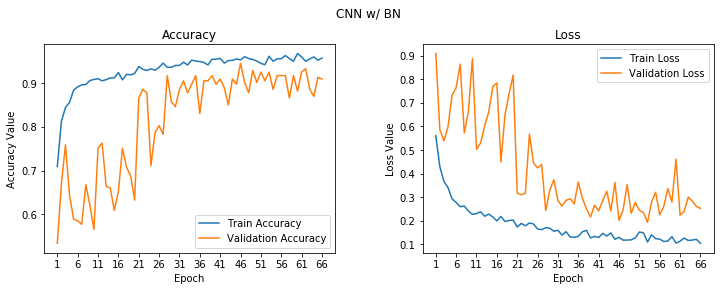

In [26]:
graph_model_history(result['history'], "CNN w/ BN")

len(train): 1907
len(valid): 253
Epoch 1/100
      1/Unknown - 1s 601ms/step - loss: 0.8553 - accuracy: 0.5703WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.844802). Check your callbacks.
15/15 [==============================] - 11s 748ms/step - loss: 0.7727 - accuracy: 0.6345 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 8s 538ms/step - loss: 0.4769 - accuracy: 0.7724 - val_loss: 0.6528 - val_accuracy: 0.6008
Epoch 3/100
15/15 [==============================] - 7s 476ms/step - loss: 0.3774 - accuracy: 0.8395 - val_loss: 0.7330 - val_accuracy: 0.5771
Epoch 4/100
15/15 [==============================] - 7s 470ms/step - loss: 0.3502 - accuracy: 0.8500 - val_loss: 0.9610 - val_accuracy: 0.5613
Epoch 5/100
15/15 [==============================] - 7s 468ms/step - loss: 0.3078 - accuracy: 0.8799 - val_loss: 0.6222 - val_accuracy: 0.5968
Epoch 6/100
15/15 [==============================] - 7s 465m

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e0cddda90>]],
      dtype=object)

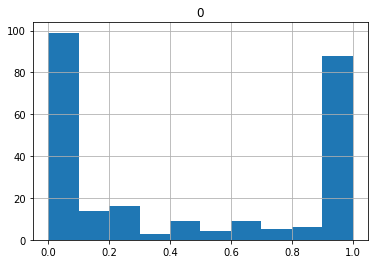

In [21]:
# Add image augmentation
model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
experiment_name = f"{project_name}_keras_cnn_bn_aug_2020_2_14"

result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=augmentations_train, 
    image_processor=None,
    band_stats=band_stats,
    model_name='keras_cnn_bn',    
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=False, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=20)

pd.DataFrame(result['y_pred_probs_valid']).hist()

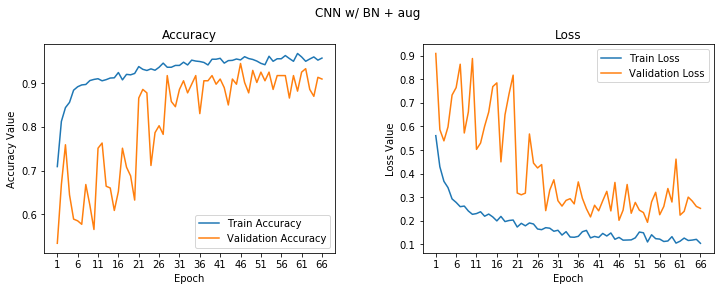

In [24]:
graph_model_history(result['history'], "CNN w/ BN + aug")

len(train): 1907
len(valid): 253
Epoch 1/100
      1/Unknown - 1s 585ms/step - loss: 0.9097 - accuracy: 0.4766WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.527151). Check your callbacks.
15/15 [==============================] - 13s 869ms/step - loss: 0.5598 - accuracy: 0.7090 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 8s 560ms/step - loss: 0.4285 - accuracy: 0.8123 - val_loss: 0.5863 - val_accuracy: 0.6680
Epoch 3/100
15/15 [==============================] - 8s 544ms/step - loss: 0.3666 - accuracy: 0.8437 - val_loss: 0.5386 - val_accuracy: 0.7589
Epoch 4/100
15/15 [==============================] - 7s 495ms/step - loss: 0.3399 - accuracy: 0.8558 - val_loss: 0.5977 - val_accuracy: 0.6443
Epoch 5/100
15/15 [==============================] - 7s 494ms/step - loss: 0.2934 - accuracy: 0.8836 - val_loss: 0.7325 - val_accuracy: 0.5889
Epoch 6/100
15/15 [==============================] - 7s 486m

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e1e280e48>]],
      dtype=object)

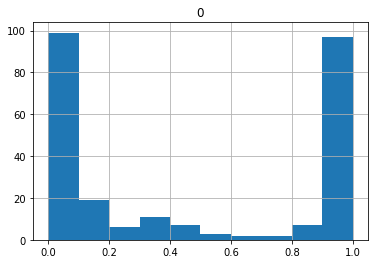

In [23]:
# Add dropout
model = basic_cnn_model_with_regularization((120, 120, 3), n_classes, should_add_dropout=True)
experiment_name = f"{project_name}_keras_cnn_bn_dropout_aug_2020_2_14"

result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=augmentations_train, 
    image_processor=None,
    band_stats=band_stats,
    model_name='keras_cnn_bn_dropout',    
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=False, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=20)

pd.DataFrame(result['y_pred_probs_valid']).hist()

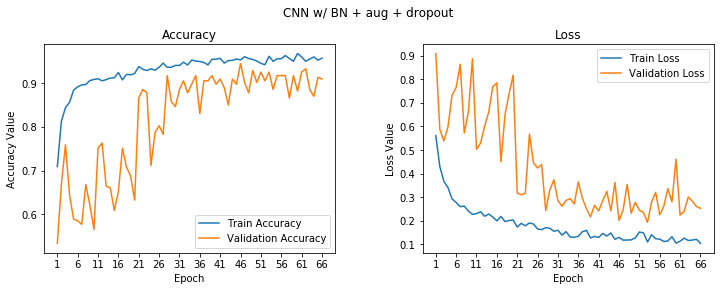

In [25]:
graph_model_history(result['history'], "CNN w/ BN + aug + dropout")

In [4]:
# Train best hyperparameter model on all data
best_experiment_name = 'cloud_and_shadow_cnn_bn_hopt_lr_0.00065432_optimizer_Adam_2020_2_14'
model, model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model, gcs_model_dir,
                                                             best_experiment_name)

result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_vaid, image_augmentations=augmentations_train, 
    image_processor=None,
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, optimizer=Adam, lr=3e-4,
    dataset_name='google_automl_dataset_large.csv',
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=20)

In [ ]:
# Try transfer learning
# https://keras.io/applications/#inceptionv3
inception_input_shape = (299, 299, 3)
model = pretrained_model(inception_v3.InceptionV3, inception_input_shape, n_classes)
experiment_name = f"{project_name}_inception_v3_aug_2020_2_14"

def inception_v3_image_processor(image):
    resized_img = cv2.resize(image, dsize=(inception_input_shape[0], inception_input_shape[1]), 
                             interpolation=cv2.INTER_CUBIC)
    return inception_v3.preprocess_input(resized_img)


result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=augmentations_train, 
    image_processor=inception_v3_image_processor,
    model_name="inception_v3",
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    batch_size=32,
    n_epochs=100, early_stopping_patience=20)

pd.DataFrame(result['y_pred_probs']).hist()

In [ ]:
graph_model_history(history.history)

In [34]:
resnet_v2_input_shape = (224, 224, 3)
model = pretrained_model(resnet_v2.ResNet50V2, resnet_v2_input_shape, n_classes)
experiment_name = f"{project_name}_resnet_v2_with_aug_2020_2_14"

def resnet_v2_image_processor(image):
    resized_img = cv2.resize(image, dsize=(resnet_v2_input_shape[0], resnet_v2_input_shape[1]), 
                             interpolation=cv2.INTER_CUBIC)
    return resnet_v2.preprocess_input(resized_img)

result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, image_augmentations=augmentations_train, 
    image_processor=resnet_v2_image_processor,
    band_stats=band_stats,
    model_name="resnet_v2",
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    batch_size=32,
    n_epochs=100, early_stopping_patience=20)

pd.DataFrame(y_pred_probs).hist()

len(train): 1907
len(valid): 253
Epoch 1/100
      1/Unknown - 1s 865ms/step - loss: 0.6877 - accuracy: 0.6250WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.766817). Check your callbacks.
60/60 [==============================] - 50s 839ms/step - loss: 0.3870 - accuracy: 0.8249 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
60/60 [==============================] - 42s 701ms/step - loss: 0.3082 - accuracy: 0.8715 - val_loss: 2.1130 - val_accuracy: 0.4427
Epoch 3/100
60/60 [==============================] - 41s 688ms/step - loss: 0.2657 - accuracy: 0.8878 - val_loss: 2.3632 - val_accuracy: 0.4625
Epoch 4/100
60/60 [==============================] - 44s 728ms/step - loss: 0.2971 - accuracy: 0.8789 - val_loss: 2.2013 - val_accuracy: 0.6245
Epoch 5/100
60/60 [==============================] - 45s 751ms/step - loss: 0.2533 - accuracy: 0.8925 - val_loss: 2.3415 - val_accuracy: 0.5968
Epoch 6/100
60/60 [==============================] - 41s

ValueError: too many values to unpack (expected 4)

In [ ]:
graph_model_history(.history)

In [ ]:
precision = precision[:-1]
recall = recall[:-1]
df = pd.concat([
    pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                  'stat_value': precision,
                  'threshold': thresholds}),
    pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                  'stat_value': recall,
                  'threshold': thresholds})    
])

In [ ]:
ax = sns.lineplot(x=recall, y=precision, color='darkblue')
ax.fill_betweean(recall,precision, color="darkblue", alpha=0.3)

In [ ]:
ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'], 
                  palette={'precision': 'red', 'recall': 'blue'})
# ax.fill_between(recall,precision, color="darkblue", alpha=0.3)